# Forecasting Vaccination Trends with Time Series Models

In this notebook, I am going to import all of the vaccine data gathered from the four most populous US cities, in the timeframe of 1/1/21-6/15/21. The vaccination data was pulled from each respective city's health department, so all files are slightly different in the information they're supplying. The first part of the notebook focuses on cleaning and inspecting the data before moving on to time series analysis

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [5]:
#importing all files
nyc = pd.read_csv('data/nyc.csv')
houston = pd.read_csv('data/Houston.csv')
la = pd.read_csv('data/la.csv')
chicago = pd.read_csv('data/chicago.csv')

## Data Cleaning

After importing all the files, I am going through to make sure each has a consistent format including date range and column name for the target variable. I also am labeling each city within the dataframe for when I merge them. 

In [6]:
# starting with new york

# adding location column
nyc['city'] = 'new york'  

# converting dates to datetime
nyc['date'] = pd.to_datetime(nyc['DATE'])  

# filtering to consistent timeframe
new_nyc = nyc[nyc['date'] >= '2021-01-01'] 

# getting consistent column name for vaccines administered
new_nyc['total_doses'] = new_nyc['ADMIN_ALLDOSES_DAILY']

In [7]:
# repeating steps with houston

houston['date'] = pd.to_datetime(houston['Date_str'])

new_houston = houston[(houston['date'] >= '2021-01-01')
                      & (houston['date'] <= '2021-06-15')]

new_houston['total_doses'] = new_houston['Vaccinated']

# need to do a groupby since there are multiple readings from each date
new_houston = new_houston.groupby(['date'], as_index=False).sum()
new_houston['city'] = 'houston'  # adding location column after groupby

In [8]:
#also need to difference the data as it is cumulative
new_houston['total_doses'] = new_houston['total_doses'].diff()

In [9]:
#chicago
chicago['city'] = 'chicago'
chicago['date'] = pd.to_datetime(chicago['Date'])
chicago['total_doses'] = chicago['Total Doses - Daily']
new_chicago = chicago[chicago['date'] >= '2021-01-01']

In [10]:
#los angeles, also need to group by date
la['date'] = pd.to_datetime(la['Date (Dose 1)'])
new_la = la[la['date'] >= '2021-01-01']
new_la = new_la.groupby(['date'], as_index=False).sum()
new_la['city'] = 'los angeles'
new_la['total_doses'] = new_la['Dose1_all']

I'm writing a function to run each dataframe through to format with only the columns I want. Then I'll look at the data overall.

In [11]:
def to_merge(dataframe):
    city_subset = dataframe[['date', 'city', 'total_doses']]
    return(city_subset)

In [12]:
nyc_merge = to_merge(new_nyc)
houston_merge = to_merge(new_houston)
chicago_merge = to_merge(new_chicago)
la_merge  = to_merge(new_la)

In [13]:
#combining dataframes
combined = pd.concat([nyc_merge, houston_merge, chicago_merge, la_merge],
                     ignore_index=True, sort=False).sort_values(by='date')

time_indexed_combined = combined.set_index('date')

time_indexed_combined.head()

,city,total_doses
date,,
2021-01-01,new york,167.0
2021-01-01,houston,NaN
2021-01-01,los angeles,1112.0
2021-01-01,chicago,48.0
2021-01-02,houston,2737.0


It looks like the overall trend is that the # vaccines per day peaked in April, when most places started making the vaccine available to more of the population. After that, the decline is pretty sharp. In the next section we'll see how this differs (or not) by location)

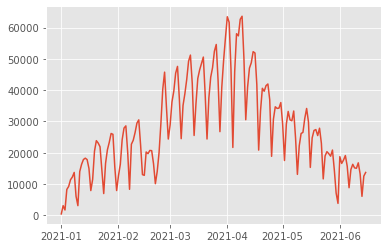

In [14]:
ti_mean = time_indexed_combined.groupby('date').mean()
plt.plot(ti_mean)

## Creating Time Series 

Now that I've cleaned and inspected the data, I'm going to format each city's dataframe for time series modeling.

Looking at the chart below, I can get an idea of how the volume of vaccinations differ from place to place, where New York City is seeing a much higher volume than Houston overall. 

In [15]:
#formatting for time series model
nyc_ts = nyc_merge.set_index('date')['total_doses']
hou_ts = houston_merge.set_index('date')['total_doses']
chi_ts = chicago_merge.set_index('date')['total_doses']
la_ts = la_merge.set_index('date')['total_doses']

In [28]:
#due to the groupby there is 1 null in the houston data
hou_ts = hou_ts.dropna()

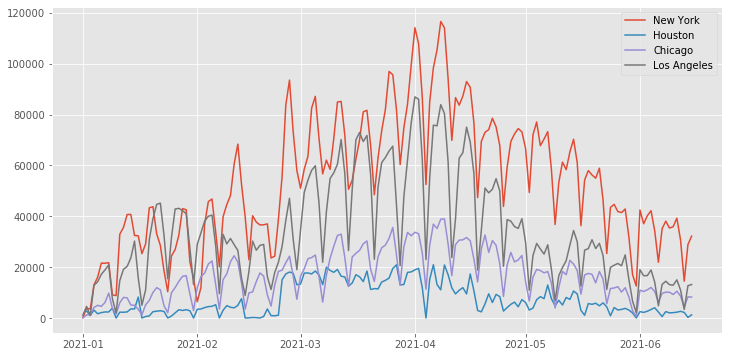

In [95]:
fig = plt.figure(figsize=(12,6))
plt.plot(nyc_ts, label='New York')
plt.plot(hou_ts, label='Houston')
plt.plot(chi_ts, label='Chicago')
plt.plot(la_ts, label='Los Angeles')
plt.legend()

## Checking for Trends

In each city there appear to be periodic trends, which would violate the assumption of stationarity that I'd need for a time series model to be effective. Below I am going to run a test to check if my data is stationary.

The function below will compare the rolling mean and standard deviation of each city for a visual of the trends. Next I'm going to use the Dickey-Fuller test. If the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary.

In [51]:
def stationarity_plot(data, city):
    
    roll_mean = data.rolling(window=7, center=False).mean()
    roll_std = data.rolling(window=7, center=False).std()
    
    dftest = adfuller(data)

    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(city))
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test for {}: \n'.format(city))

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

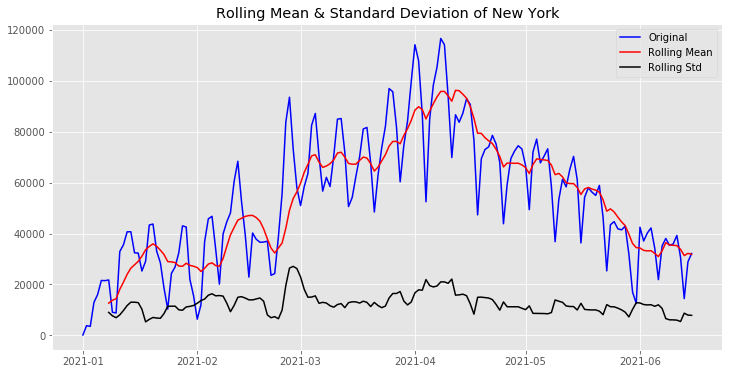

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -1.198953
p-value                          0.674046
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


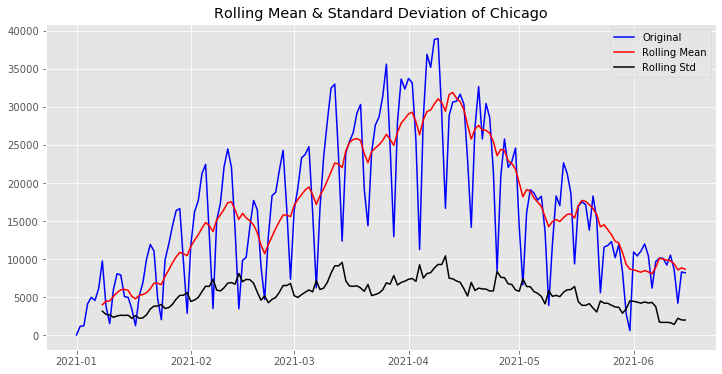

Results of Dickey-Fuller Test for Chicago: 

Test Statistic                  -1.712065
p-value                          0.424907
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


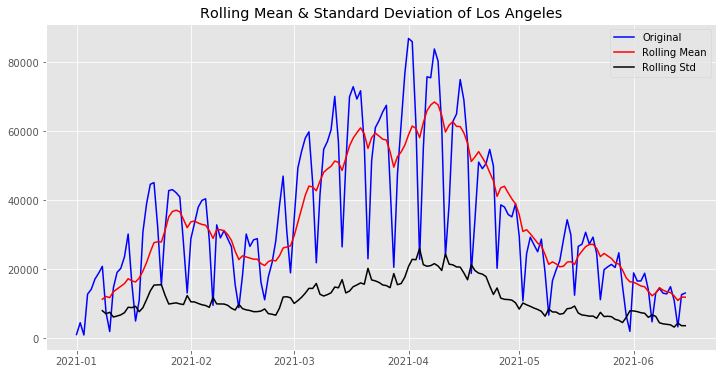

Results of Dickey-Fuller Test for Los Angeles: 

Test Statistic                  -1.547956
p-value                          0.509669
#Lags Used                       8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


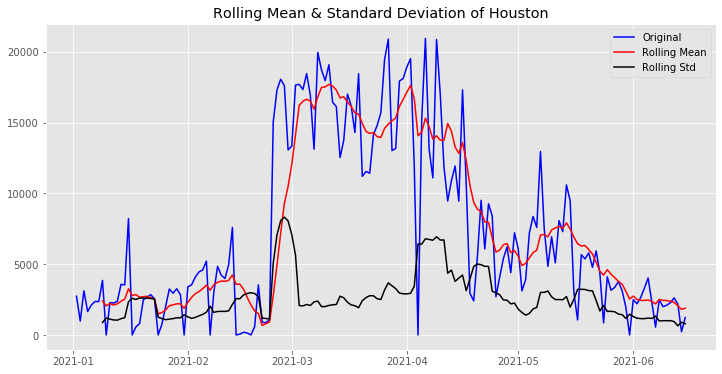

Results of Dickey-Fuller Test for Houston: 

Test Statistic                  -1.540347
p-value                          0.513466
#Lags Used                       7.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [19]:
stationarity_plot(nyc_ts, 'New York')
stationarity_plot(chi_ts, 'Chicago')
stationarity_plot(la_ts, 'Los Angeles')
stationarity_plot(hou_ts, 'Houston')

Results uphold the null hypothesis: the time series is not stationary for any of the cities. So I need to look into removing trends.

To determine the best way to transform the data, I'm going to look at 2 different visuals: log transformations and square root transformations.

## Decomposition

In [23]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(ts):
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

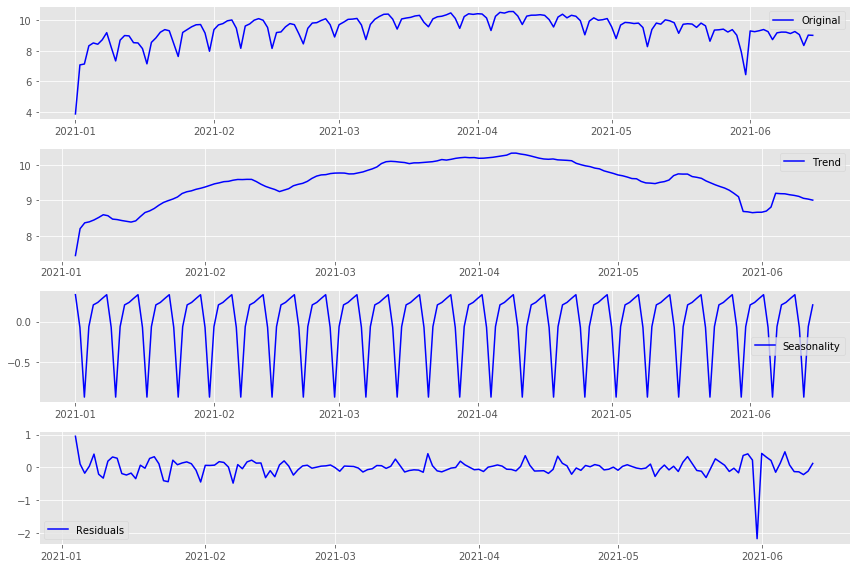

In [33]:
decompose(chi_ts)

With each time series, there is a trend that increases and levels off in different ways. There is clear seasonality which may have to do with the majority of people receiving their vaccines on weekends. I'll need to remove the seasonality to make sure the time series are stationary. 

To do this, I am going to first log transform each to make the time series more uniform over time. Then, I'll take the rolling mean of each and subtract it from the log transformed time series.

In [74]:
def detrend(ts):
    ts_log = np.log(ts)
    roll_mean = ts_log.rolling(window=7).mean()

    # Subtract the moving average from the log transformed data
    data_minus_roll_mean = ts_log - roll_mean

    # Print the first 10 rows
    data_minus_roll_mean.dropna(inplace=True)
    
    fig = plt.figure(figsize=(11,7))
    plt.plot(data_minus_roll_mean)
    plt.title('Vaccines with rolling mean subtracted')
    plt.show(block=False)

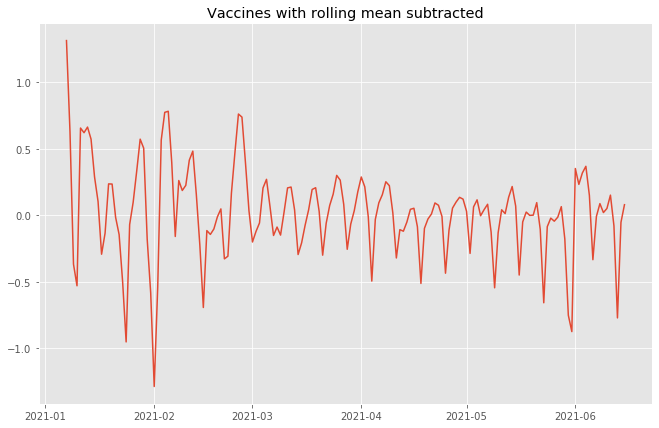

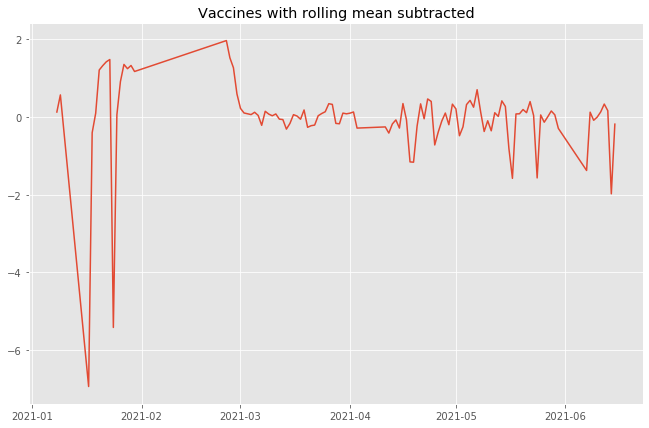

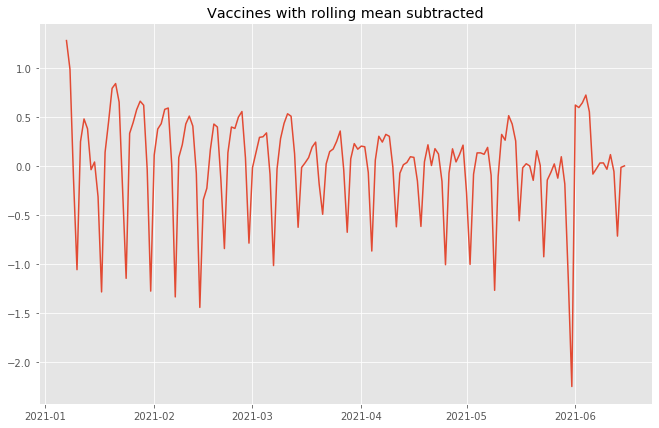

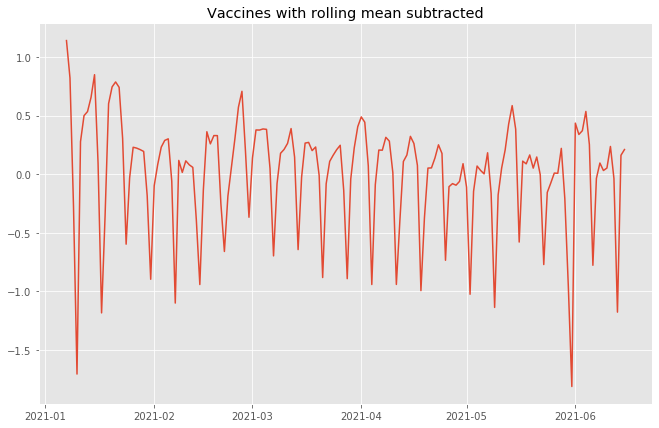

In [75]:
nyc_detrended = detrend(nyc_ts)
hou_detrended = detrend(hou_ts)
chi_detrended = detrend(chi_ts)
la_detrended = detrend(la_ts)

This already looks better so I'm going to check again for stationarity.


It looks like the NYC data has just made it.

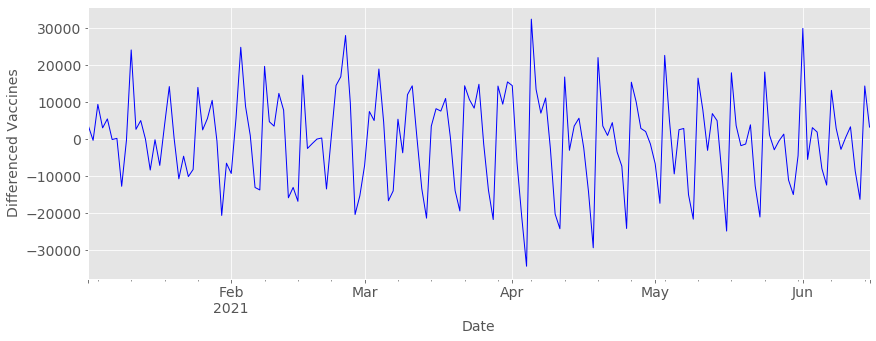

In [72]:
## Differencing

nyc_diff = nyc_ts.diff()
nyc_diff.dropna(inplace=True)
nyc_diff.plot(color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Vaccines', fontsize=14);

In [58]:
# stationarity_plot(nyc_diff, 'New York')

## Checking Correlations

In [63]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams

In [65]:
def correlation_plots(df):
    rcParams['figure.figsize'] = 14, 5
    plot_acf(df, lags=50);

    rcParams['figure.figsize'] = 14, 5
    plot_pacf(df, lags=50);

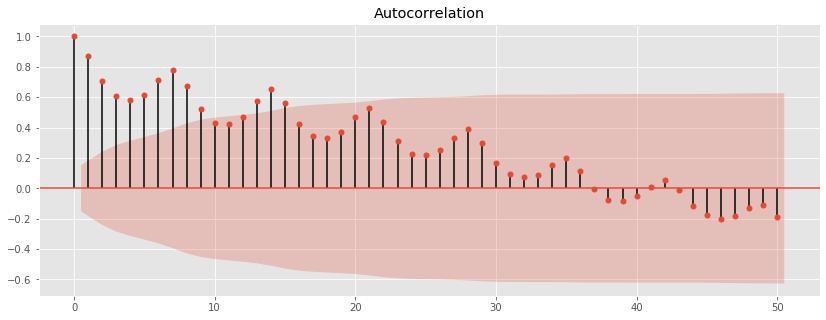

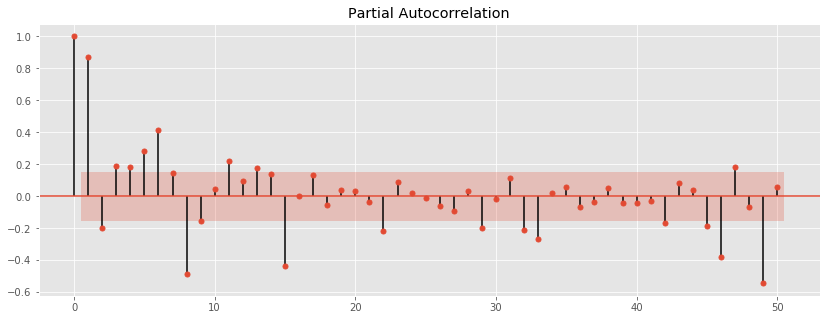

In [67]:
correlation_plots(nyc_ts)

## Time Series Modeling

In [76]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [79]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(nyc_diff,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =3561.1984817214825
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =3292.391617012734
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =3445.3558155923733
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =3095.5070696274756
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =3320.4074173093213
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =3291.0457901810664
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3166.6677444971697
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3081.3539422309705
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =3537.5239630509286
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3271.114791485963
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =3412.007021788879
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3071.808707601768
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =3319.7195020303634
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =3271.2671852634357
ARIMA (0, 

In [80]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 1, 1, 12)
aic           3023.76
Name: 43, dtype: object

In [81]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(nyc_diff, 
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5965      0.122      4.902      0.000       0.358       0.835
ma.L1         -0.8652      0.088     -9.882      0.000      -1.037      -0.694
ma.S.L12      -1.0684      0.041    -26.239      0.000      -1.148      -0.989
sigma2      1.507e+08   1.58e-10   9.51e+17      0.000    1.51e+08    1.51e+08


all featrues have p values > than 0.05 so we can consider them significant

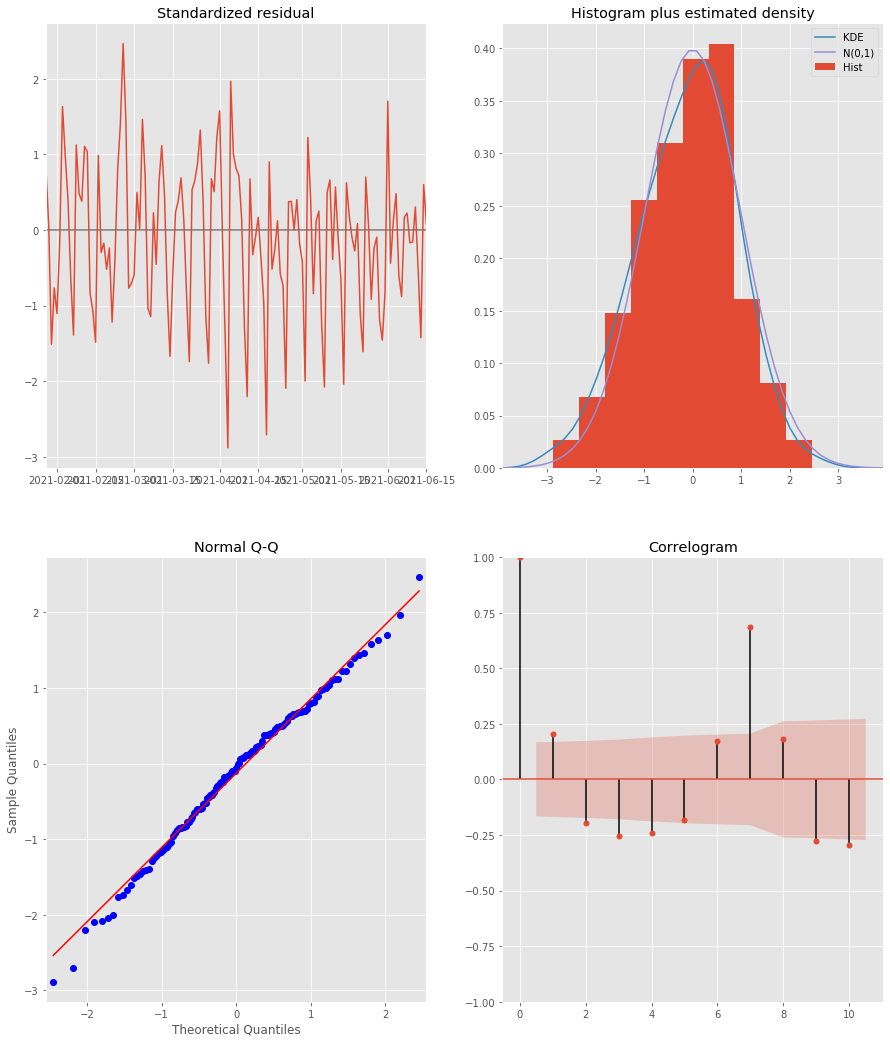

In [82]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

ex evaluation

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## validating the model

In [85]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-02'), dynamic=False)
pred_conf = pred.conf_int()

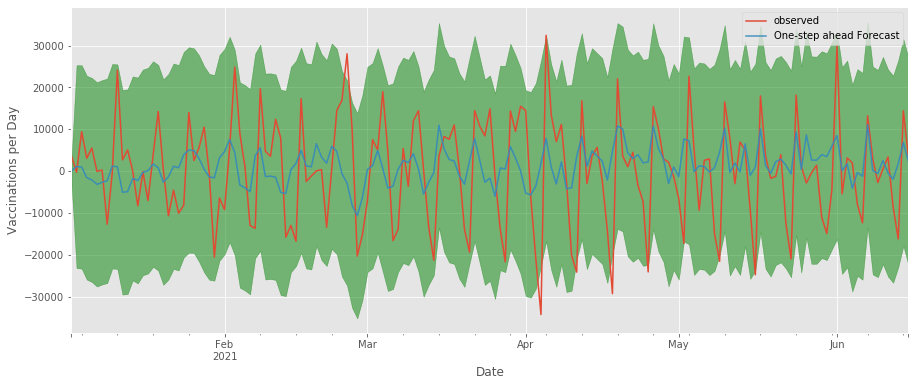

In [87]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nyc_diff['2021':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Vaccinations per Day')
plt.legend()

plt.show()

In [88]:
# Get the real and predicted values
forecasted = pred.predicted_mean
true = nyc_ts['2021-01-07':]

# Compute the mean square error
mse = ((forecasted - true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3483381418.12


In [89]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2021-01-02'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

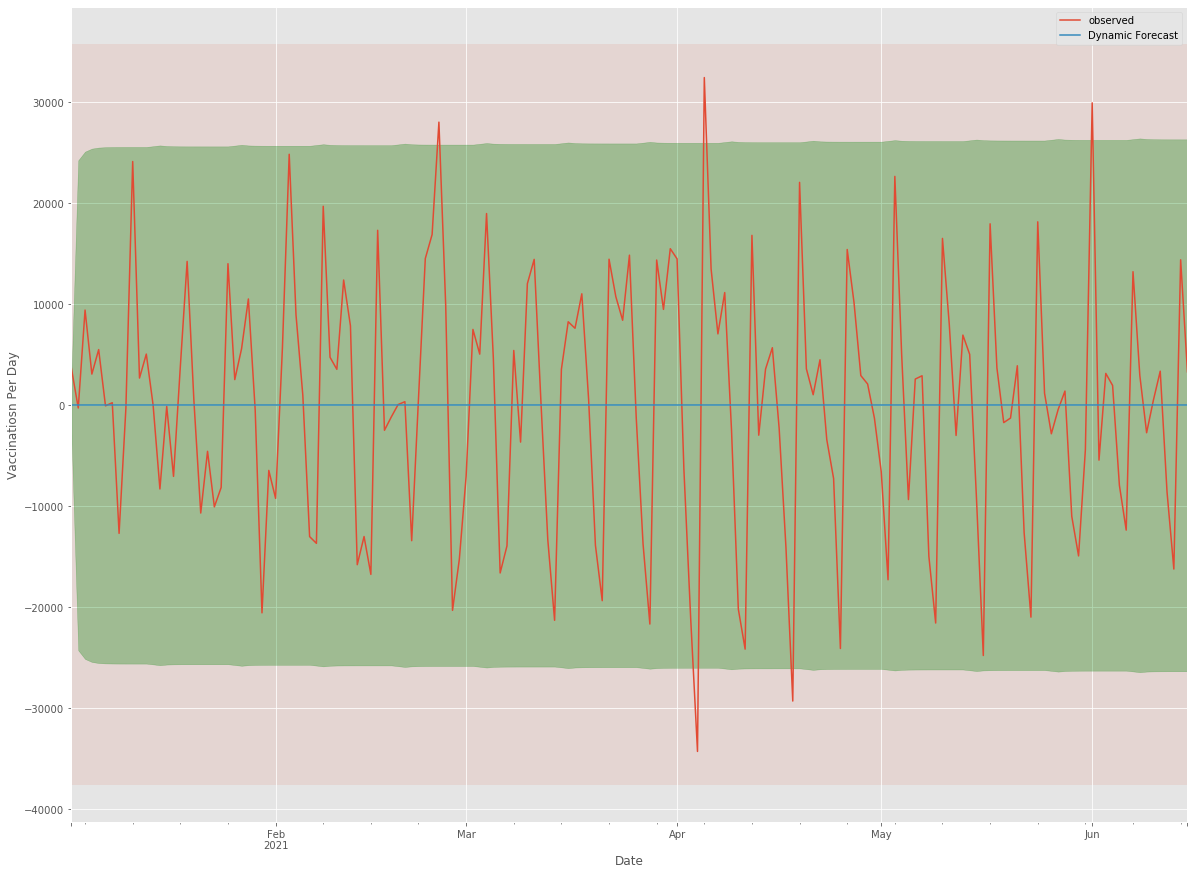

In [90]:
# Plot the dynamic forecast with confidence intervals.

ax = nyc_diff['2021':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-02'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Vaccinatiosn Per Day')

plt.legend()
plt.show()

In [91]:
# Get the real and predicted values
forecasted = pred_dynamic.predicted_mean
true = nyc_diff['2021-01-02':]

# Compute the mean square error
mse = ((forecasted - true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 155006570.48


In [92]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

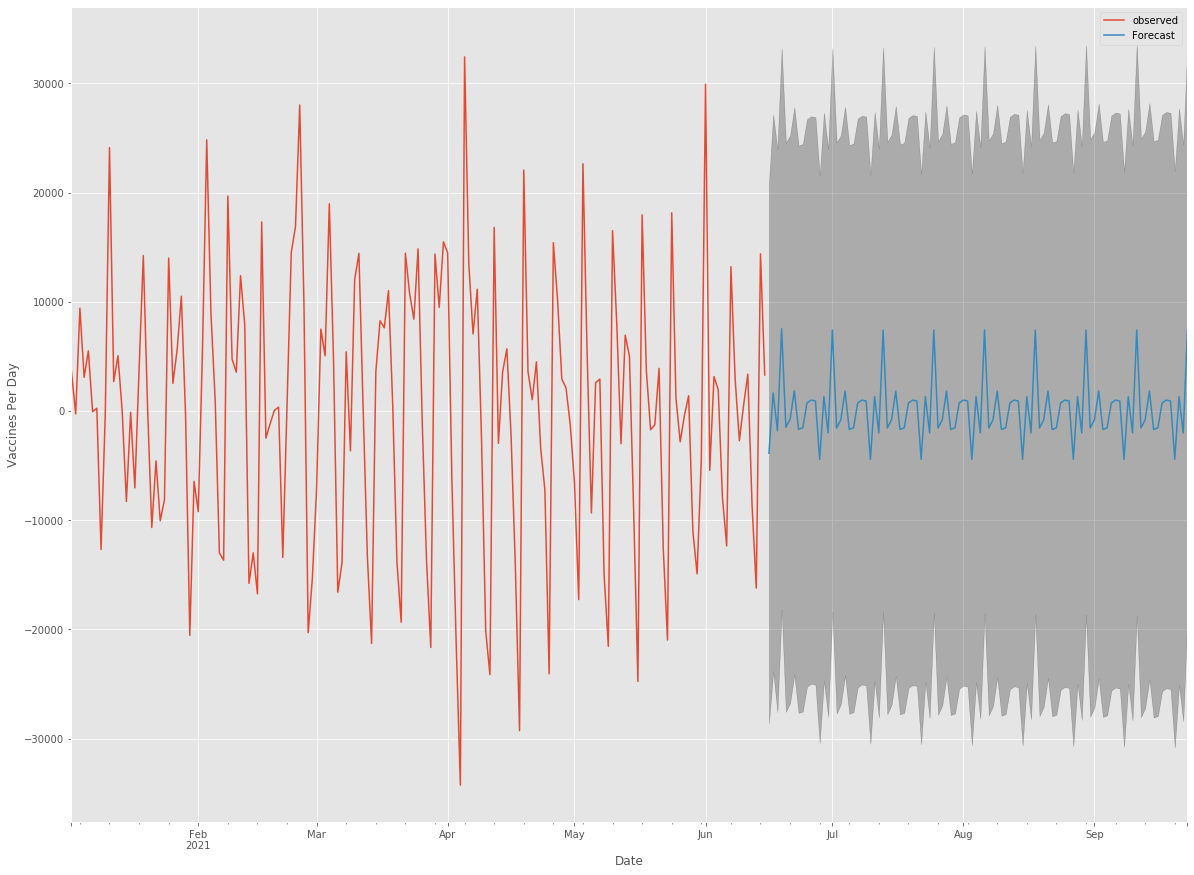

In [93]:
# Plot future predictions with confidence intervals
ax = nyc_diff.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Vaccines Per Day')

plt.legend()
plt.show()